In [2]:
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
#Set directory location where dataset contained
os.chdir("/content/drive/MyDrive/Project-1/Circle_Unet")

In [4]:
import os
import pathlib
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.io as sio
from matplotlib import pyplot 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras import models
from tensorflow import keras
import pandas as pd
import datetime
%load_ext google.colab.data_table
import cv2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython import display
import random
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import argparse
import logging
import sys
from pathlib import Path
import time
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Conv2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import add,multiply
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  

In [5]:
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [6]:
test_file = np.load('mask_set.npz')
X_test = test_file['X'] # Raw images
y_test = test_file['y'] # Instance Segmentation Masks
train_file = np.load('train-set.npz')
X_train = train_file['X'] # Raw images
y_train = train_file['y'] # Instance Segmentation Masks

In [7]:
print(X_train.shape)
print(X_test.shape)


(544, 256, 256, 1)
(124, 256, 256, 1)


In [9]:
x_train, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=34, shuffle=True)

In [10]:
num_train_examples = len(x_train)
num_val_examples = len(x_val)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 408
Number of validation examples: 136


<Figure size 720x1080 with 0 Axes>

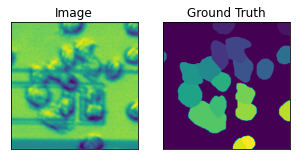

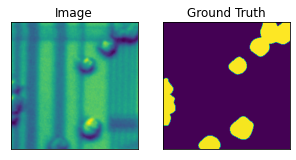

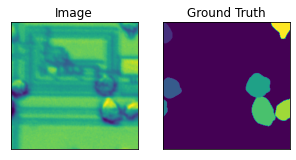

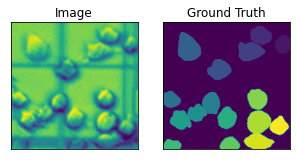

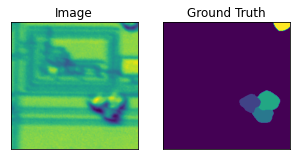

In [11]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  id = r_choices[i // 2]
  cells = X_train[id]
  cells = cells.reshape((256,256))
  ground_truth = y_train[id]
  ground_truth = ground_truth.reshape((256,256))
  plt.figure(figsize=(5,10))
  plt.subplot(1,2,1)
  plt.imshow(cells)
  plt.title("Image"), plt.xticks([]), plt.yticks([])
  plt.subplot(1,2,2)
  plt.imshow(ground_truth)
  plt.title("Ground Truth"), plt.xticks([]), plt.yticks([])
 

# Attention Based Circle UNet

In [19]:
def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)
    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)
    f = Activation('relu')(add([theta_x, phi_g]))
    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)
    rate = Activation('sigmoid')(psi_f)
    att_x = multiply([x, rate])
    #print(att_x.shape)
    return att_x


def conv3x3(x, out_filters, strides=(1, 1)):
    x = Conv2D(out_filters, 3, padding='same', strides=strides, use_bias=False, kernel_initializer='he_normal')(x)
    return x


def Conv2d_BN(x, nb_filter, kernel_size, strides=(1, 1), padding='same', use_activation=True):
    x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    if use_activation:
        x = Activation('relu')(x)
        return x
    else:
        return x


def basic_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    x = conv3x3(input, out_filters, strides)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = conv3x3(x, out_filters)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def bottleneck_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    expansion = 4
    de_filters = int(out_filters / expansion)

    x = Conv2D(de_filters, 1, use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(de_filters, 3, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(out_filters, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x

def circle_connect(layer1,layer2,stride,out_filters):
    residual = Conv2D(out_filters, 1, strides=stride, use_bias=False, kernel_initializer='he_normal')(layer1)
    residual = BatchNormalization(axis=3)(residual)
    x = add([layer2, residual])

    return x


def ATTCircleUNet(height, width, channel, classes):
    input = Input(shape=(height, width, channel))
    k_size= 64
    conv1_1 = Conv2D(k_size, 7, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(input)
    conv1_1 = BatchNormalization(axis=3)(conv1_1)
    conv1_1 = Activation('relu')(conv1_1)
    conv1_2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv1_1)

    # conv2_x  1/4
    conv2_1 = bottleneck_Block(conv1_2, 2*k_size, strides=(1, 1), with_conv_shortcut=True)
    conv2_2 = bottleneck_Block(conv2_1, 2*k_size)
    conv2_3 = bottleneck_Block(conv2_2, 2*k_size)
    


    # conv3_x  1/8
    conv3_1 = bottleneck_Block(conv2_3, 4*k_size, strides=(2, 2), with_conv_shortcut=True)
    conv3_2 = bottleneck_Block(conv3_1, 4*k_size)
    conv3_3 = bottleneck_Block(conv3_2, 4*k_size)
    conv3_4 = bottleneck_Block(conv3_3, 4*k_size)
    #print("conv 3_4 shape = " ,conv3_4.shape)
    # conv2_1 to conv3_4
    cc1 = circle_connect(conv2_1,conv3_4,(2,2),4*k_size)    
    # print("cc1 shape",cc1.shape)

    # conv4_x  1/16
    conv4_1 = bottleneck_Block(conv3_4, 8*k_size, strides=(2, 2), with_conv_shortcut=True)
    conv4_2 = bottleneck_Block(conv4_1, 8*k_size)
    conv4_3 = bottleneck_Block(conv4_2, 8*k_size)
    conv4_4 = bottleneck_Block(conv4_3, 8*k_size)
    conv4_5 = bottleneck_Block(conv4_4, 8*k_size)
    conv4_6 = bottleneck_Block(conv4_5, 8*k_size)
    conv4_7 = bottleneck_Block(conv4_6, 8*k_size)
    conv4_8 = bottleneck_Block(conv4_7, 8*k_size)
    conv4_9 = bottleneck_Block(conv4_8, 8*k_size)
    conv4_10 = bottleneck_Block(conv4_9, 8*k_size)
    conv4_11 = bottleneck_Block(conv4_10, 8*k_size)
    # conv3_1 to conv 4_11
    cc2 = circle_connect(conv3_1,conv4_11,(2,2),8*k_size)    

    conv4_12 = bottleneck_Block(conv4_11, 8*k_size)
    conv4_13 = bottleneck_Block(conv4_12, 8*k_size)
    conv4_14 = bottleneck_Block(conv4_13, 8*k_size)
    conv4_15 = bottleneck_Block(conv4_14, 8*k_size)
    conv4_16 = bottleneck_Block(conv4_15, 8*k_size)
    conv4_17 = bottleneck_Block(conv4_16, 8*k_size)
    conv4_18 = bottleneck_Block(conv4_17, 8*k_size)
    conv4_19 = bottleneck_Block(conv4_18, 8*k_size)
    conv4_20 = bottleneck_Block(conv4_19, 8*k_size)
    conv4_21 = bottleneck_Block(conv4_20, 8*k_size)
    conv4_22 = bottleneck_Block(conv4_21, 8*k_size)
    conv4_23 = bottleneck_Block(conv4_22, 8*k_size)
    # conv 4_11 to conv 4_23
    cc3 = circle_connect(conv4_11,conv4_23,(1,1),8*k_size)    

    # conv5_x  1/32
    conv5_1 = bottleneck_Block(conv4_23, 16*k_size, strides=(2, 2), with_conv_shortcut=True)
    conv5_2 = bottleneck_Block(conv5_1, 16*k_size)
    conv5_3 = bottleneck_Block(conv5_2, 16*k_size)
    # conv 4_1 to conv 5_3 
    cc4 = circle_connect(conv4_1,conv5_3,(2,2),16*k_size)    

    up6 = Conv2d_BN(UpSampling2D(size=(2, 2))(conv5_3), 8*k_size, 2)
    merge6 = concatenate([conv4_23, up6], axis=3)
    up6 = Conv2d_BN(UpSampling2D(size=(2, 2))(conv5_3), 8*k_size, 2)
    attention_s6 = attention_block_2d(up6, conv4_23, 8*k_size)
    merge6 = concatenate([attention_s6, up6 ] , axis=3 )
    conv6 = Conv2d_BN(merge6, 8*k_size, 3)
    conv6 = Conv2d_BN(conv6, 8*k_size, 3)


    up7 = Conv2d_BN(UpSampling2D(size=(2, 2))(conv6), 4*k_size, 2)
    merge7 = concatenate([conv3_4, up7], axis=3)    
    up7 = Conv2d_BN(UpSampling2D(size=(2, 2))(conv6), 4*k_size, 2)
    attention_s7 = attention_block_2d(up7, conv3_4, 4*k_size)
    merge7 = concatenate([attention_s7, up7], axis=3)
    conv7 = Conv2d_BN(merge7, 4*k_size, 3)
    conv7 = Conv2d_BN(conv7, 4*k_size, 3)

    up8 = Conv2d_BN(UpSampling2D(size=(2, 2))(conv7), 2*k_size, 2)
    merge8 = concatenate([conv2_3, up8], axis=3)
    up8 = Conv2d_BN(UpSampling2D(size=(2, 2))(conv7), 2*k_size, 2)
    attention_s8 = attention_block_2d(up8, conv2_3, 2*k_size)
    merge8 = concatenate([attention_s8, up8], axis=3)
    conv8 = Conv2d_BN(merge8, 2*k_size, 3)
    conv8 = Conv2d_BN(conv8, 2*k_size, 3)

    up9 = Conv2d_BN(UpSampling2D(size=(2, 2))(conv8), k_size, 2)
    merge9 = concatenate([conv1_1, up9], axis=3)
    up9 = Conv2d_BN(UpSampling2D(size=(2, 2))(conv8), k_size, 2)
    attention_s9 = attention_block_2d(up9, conv1_1, k_size)
    merge9 = concatenate([attention_s9, up9], axis=3)
    conv9 = Conv2d_BN(merge9, k_size, 3)
    conv9 = Conv2d_BN(conv9, k_size, 3)

    up10 = Conv2d_BN(UpSampling2D(size=(2, 2))(conv9), k_size, 2)
    conv10 = Conv2d_BN(up10, k_size, 3)
    conv10 = Conv2d_BN(conv10, k_size, 3)

    conv11 = Conv2d_BN(conv10, classes, 1, use_activation=None)
    activation = Activation('sigmoid', name='Classification')(conv11)

    model = Model(inputs=input, outputs=activation)
    return model


In [ ]:
def sim_UNet(height, width, channel, classes):
    input = Input(shape=(height, width, channel))

    conv1_1 = Conv2D(16, 7, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(input)
    conv1_1 = BatchNormalization(axis=3)(conv1_1)
    conv1_1 = Activation('relu')(conv1_1)
    conv1_2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv1_1)

    conv2_1 = Conv2D(16, 7, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(conv1_2)
    conv2_1 = BatchNormalization(axis=3)(conv2_1)
    conv2_1 = Activation('relu')(conv2_1)
    conv2_2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv2_1)
    
    up9 = Conv2d_BN(UpSampling2D(size=(4, 4))(conv2_2), 1, 2)
    conv9 = Conv2d_BN(up9, 1, 3)

    up10 = Conv2d_BN(UpSampling2D(size=(4, 4))(conv9), 1, 2)
    conv10 = Conv2d_BN(up10, 1, 3)

    activation = Activation('sigmoid', name='Classification')(conv10)

    model = Model(inputs=input, outputs=activation)
    return model

    

In [14]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [15]:
from tensorflow.keras.utils import to_categorical
ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.categorical_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

In [16]:
def F1Loss(targets, inputs, beta=1):
   inputs = K.flatten(inputs)
   targets = K.flatten(targets)
   #True Positives, False Positives & False Negatives
   TP = K.sum((inputs * targets))
   FP = K.sum(((1-targets) * inputs))
   FN = K.sum((targets * (1-inputs)))
   denom = (1 + beta**2) * TP + (beta**2)*FN + FP
   Fb = (1 + beta**2) * TP / denom
   return Fb


def Categorical_Focal_Loss(y_true, y_pred, beta=1, alpha=[[.25, .25, .25]], gamma=2):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    # Calculate Cross Entropy
    cross_entropy = -y_true * K.log(y_pred)

    # Calculate Focal Loss
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

    # Compute mean loss in mini_batch
    return K.mean(K.sum(loss, axis=-1))



In [17]:
ALPHA = 0.5 # < 0.5 penalises FP more, > 0.5 penalises FN more
CE_RATIO = 0.5 #weighted contribution of modified CE loss compared to Dice loss

def Combo_loss(targets, inputs, eps=1e-9, smooth=1e-6):
    targets = K.flatten(targets)
    inputs = K.flatten(inputs)
    
    intersection = K.sum(targets * inputs)
    dice = (2. * intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    inputs = K.clip(inputs, eps, 1.0 - eps)
    out = - (ALPHA * ((targets * K.log(inputs)) + ((1 - ALPHA) * (1.0 - targets) * K.log(1.0 - inputs))))
    weighted_ce = K.mean(out, axis=-1)
    combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)
    
    return combo

In [20]:
img_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
batch_size = 8
epochs = 15

model = ATTCircleUNet(height=img_shape[0], width=img_shape[1], channel=img_shape[2], classes=1)
#model = sim_UNet(height=img_shape[0], width=img_shape[1], channel=img_shape[2], classes=1)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 128, 128, 64) 3136        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_110 (BatchN (None, 128, 128, 64) 256         conv2d_113[0][0]                 
__________________________________________________________________________________________________
activation_103 (Activation)     (None, 128, 128, 64) 0           batch_normalization_110[0][0]    
______________________________________________________________________________________________

In [21]:
from scipy.ndimage import distance_transform_edt as distance
def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)


def surface_loss_keras(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)



In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3) #tf.keras.optimizers.RMSprop(learning_rate=1e-3, clipvalue=1.) #
decay_steps = 1000
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    1e-3, decay_steps)
model.compile(optimizer=opt, loss=surface_loss_keras,  metrics=[#tf.keras.metrics.MeanIoU(num_classes=2),
                                                       tf.keras.metrics.AUC(num_thresholds=3),
                                                       tf.keras.metrics.BinaryAccuracy(),
                                                       tf.keras.metrics.CategoricalCrossentropy(),
                                                       tf.keras.metrics.Precision(),
                                                       tf.keras.metrics.Recall()])


# Split into training and validation

save_model_path = '/tmp/weights.hdf5'


callbacks = [keras.callbacks.LearningRateScheduler(lr_decayed_fn, verbose=1),
             tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', mode='max', save_best_only=True)]
#wandb.init(project='U-Net-cellseg', resume='allow', entity='ibis')
  
history = model.fit(x_train,y_tr,
                   steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                   epochs=epochs,
                   validation_data=(x_val,y_val),
                   validation_steps=int(np.ceil(x_val.shape[0] / float(batch_size))),
                   callbacks=[callbacks],
                    verbose=1, 
                    shuffle=True)
#wandb.finish()
model.save(MODEL_TF)

Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
51/51 [==============================] - 98s 971ms/step - loss: 9.3908 - auc: 0.6620 - binary_accuracy: 0.5024 - categorical_crossentropy: 0.0000e+00 - precision: 0.4386 - recall: 0.6366 - val_loss: 30.5962 - val_auc: 0.5000 - val_binary_accuracy: 0.0081 - val_categorical_crossentropy: 0.0000e+00 - val_precision: 0.2477 - val_recall: 1.0000


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009999975, shape=(), dtype=float32).
51/51 [==============================] - 47s 917ms/step - loss: 7.1818 - auc: 0.7645 - binary_accuracy: 0.5183 - categorical_crossentropy: 0.0000e+00 - precision: 0.5192 - recall: 0.8202 - val_loss: 3.2635 - val_auc: 0.5000 - val_binary_accuracy: 0.7523 - val_categorical_crossentropy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009999902, shape=(), dtype=float32).
51/51 [==============================] - 46s 913ms/step - loss: 6.1794 - auc: 0.7851 - binary_accuracy: 0.5265 - categorical_crossentropy: 0.0000e+00 - precision: 0.5380 - recall: 0.8501 - val_loss: 4.0937 - val_auc: 0.5033 - val_binary_accuracy: 0.7509 - val_categorical_crossentropy: 0.0000e+00 - val_precision: 0.6067 - val_recall: 0.0085
Epoch 4/15

Epoch 00004: LearningRateScheduler setting learning 

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


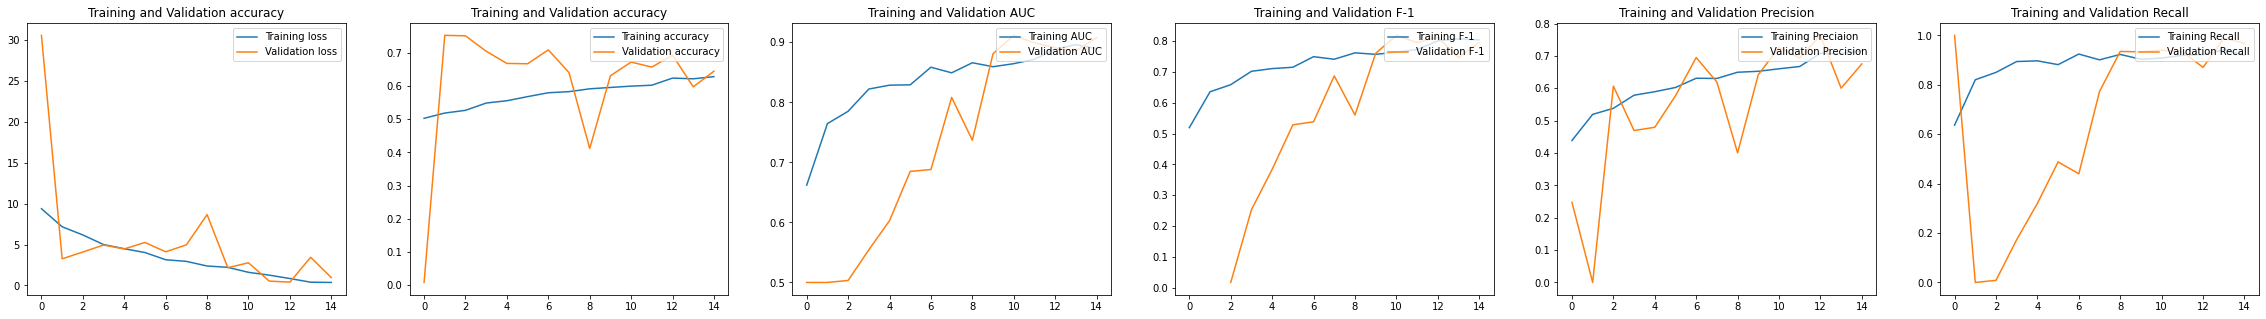

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']


accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']

auc = history.history['auc']
val_auc = history.history['val_auc']

prec = np.copy(history.history['precision'])
val_prec = np.copy(history.history['val_precision'])


recall = np.copy(history.history['recall'])
val_recall = np.copy(history.history['val_recall'])

f1_score = 2 * (prec*recall) / (prec + recall)
val_f1_score = 2 * (val_prec*  val_recall) / (val_prec + val_recall)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(40, 5))
plt.subplot(1, 6, 1)
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 6, 2)
plt.plot(epochs_range, accuracy, label='Training accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 6, 3)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.title('Training and Validation AUC')

plt.subplot(1, 6, 4)
plt.plot(epochs_range, f1_score, label='Training F-1')
plt.plot(epochs_range, val_f1_score, label='Validation F-1')
plt.legend(loc='upper right')
plt.title('Training and Validation F-1')

plt.subplot(1, 6, 5)
plt.plot(epochs_range, prec, label='Training Preciaion')
plt.plot(epochs_range, val_prec, label='Validation Precision')
plt.legend(loc='upper right')
plt.title('Training and Validation Precision')

plt.subplot(1, 6, 6)
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.legend(loc='upper right')
plt.title('Training and Validation Recall')


plt.show()

In [ ]:
hist = model.evaluate(X_test, y_test)
f1_score = 2 * (hist[4]*hist[5]) / (hist[4] + hist[5])
print('----------------Test Results----------------')
print('Loss: {}'.format(hist[0]))
print('AUC: {}'.format(hist[1]))
print('Binary Accuracy: {}'.format(hist[2]))
print('Precision: {}'.format(hist[4]))
print('Recall: {}'.format(hist[5]))
print('F1-Score: {}'.format(f1_score))

4/4 [==============================] - 7s 913ms/step - loss: -0.5883 - auc_2: 0.8648 - binary_accuracy: 0.9189 - categorical_crossentropy: 0.0000e+00 - precision_2: 0.8077 - recall_2: 0.7751
----------------Test Results----------------
Loss: -0.5883277058601379
AUC: 0.864774763584137
Binary Accuracy: 0.9189224243164062
Precision: 0.8077281713485718
Recall: 0.7751136422157288
F1-Score: 0.7910848948378607


(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)


<Figure size 720x1080 with 0 Axes>

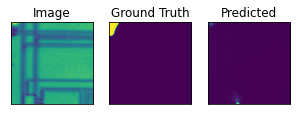

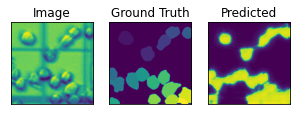

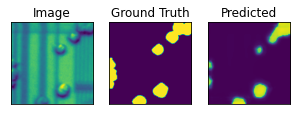

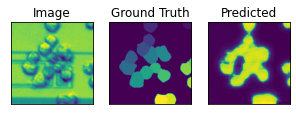

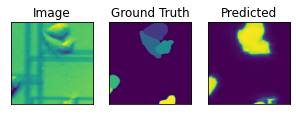

In [ ]:
# Make predictions based on our test dataset
display_num = 5

r_choices = np.random.choice(124, 5)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  id = r_choices[i // 2]
  cells = x_val[id]
  cells = cells.reshape((256,256))
  cells1 = np.expand_dims(cells, axis=0)

  ground_truth = y_val[id]
  ground_truth = ground_truth.reshape((256,256))
  #ground_truth1 = np.expand_dims(ground_truth, axis=0)

  ground_truth_predicted = model.predict(cells1)
  print(ground_truth_predicted.shape)
  ground_truth_predicted = ground_truth_predicted.reshape((256,256))
  #ground_truth_predicted = np.expand_dims(ground_truth_predicted, axis=0)

  
  plt.figure(figsize=(5,10))
  plt.subplot(1,3,1)

  plt.imshow(cells)
  plt.title("Image"), plt.xticks([]), plt.yticks([])
  plt.subplot(1,3,2)
  plt.imshow(ground_truth)
  plt.title("Ground Truth"), plt.xticks([]), plt.yticks([])
  plt.subplot(1,3,3)
  plt.imshow(ground_truth_predicted)
  plt.title("Predicted"), plt.xticks([]), plt.yticks([])

In [24]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(len(x_train)):
    yield([x_train[i,:,:,:].reshape(1,256,256,1).astype(np.float32)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

24544632

In [25]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  #x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], x_test_)
  interpreter.invoke()
  y_pred = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred


In [ ]:
# Calculate predictions with full software
y_pred = np.reshape(np.argmax(model.predict(X_test), axis=3),[len(X_test),256,256])
y_true = y_test.reshape(124,256,256)

test_acc = float(sum(sum(sum(y_pred == y_true))) / (256*256*124))
print('Test accuracy with model:')
print(f"{test_acc:.2%}")
y_test_pred_no_quant_tflite=np.empty([X_test.shape[0],256,256])
y_test_pred_tflite=np.empty([X_test.shape[0],256,256])
# Calculate predictions with tensorflow lite
for i in range(0,X_test.shape[0]):
  y_test_pred_no_quant_tflite[i,:,:]=np.argmax(predict_tflite(model_no_quant_tflite, X_test[i:i+1,:,:,:]), axis=2)
#print(y_test_pred_no_quant_tflite.shape)
test_acc = float(sum(sum(sum(y_test_pred_no_quant_tflite == y_true))) / (256*256*124))
print('Test accuracy with model tf lite:')
print(f"{test_acc:.2%}")


# Calculate predictions with tensorflow lite quantized model
for i in range(0,X_test.shape[0]):
  y_test_pred_tflite[i,:,:]=np.argmax(predict_tflite(model_tflite, X_test[i:i+1,:,:,:]), axis=2)
#print(y_test_pred_tflite.shape)
test_acc = float(sum(sum(sum(y_test_pred_tflite == y_true))) / (256*256*124))
print('Test accuracy with model quantized:')
print(f"{test_acc:.2%}")



y_test_pred_tflite=np.empty([X_test.shape[0],256,256])

# Calculate predictions with tensorflow lite quantized model
for i in range(0,X_test.shape[0]):
  y_test_pred_tflite[i,:,:]=(predict_tflite(model_tflite, X_test[i:i+1,:,:,:])).reshape(256,256)
y_true = y_test

y_test_tflite = {"y_test_pred_tflite":y_test_pred_tflite}
sio.savemat('models/tflite_pred.mat',y_test_tflite)


Test accuracy with model:
80.20%
(124, 256, 256)
Test accuracy with model tf lite:
80.20%


In [ ]:
# Calculate size
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

# Compare size
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {0} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

Size                             
Model                                                                  
TensorFlow Lite            94506736 bytes          (reduced by 0 bytes)
TensorFlow Lite Quantized   24544056 bytes  (reduced by 69962680 bytes)

In [ ]:

# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [69.5 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2

In [ ]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}